<h1 style="color:Blue; font-size:40px;">Advanced Topic - Building an Interactive Map</h1>


The goal of this section is to create an interactive map of Europe where users can explore cities and view relevant information such as country, population, average salary, and cost of living. This task is divided into two main parts:

## **Group Members**

- Diogo Gonçalves - 20241817
- Gustavo Franco - 20241816
- João Marques - 20241771
- Juan Mendes - 20241804

## **Objectives**

**1. Web Scraping**

- Starting from the Wikipedia Main Page
(https://en.wikipedia.org/wiki/Main_Page), extract the geographical coordinates
of each city.
- The coordinates must be obtained only through web scraping of this source
- Ensure that each city is matched with its corresponding dataset entry
accurately.


**2. Interactive Map**

- Using the scraped coordinates, build an interactive map of Europe that
highlights all cities.
- Each city marker should display the following when hovered/clicked:
  - Country
  - Population
  - Average monthly salary
  - Average cost of living
- You may use any tools covered in class (e.g., plotly, geopandas, etc).
- A baseline example is shown below. You are free to personalize the design
(colors, popups, etc.), as long as the required information is included.


## **Install the Needed Libraries**

In [457]:
!pip install requests
!pip install beautifulsoup4
!pip install selenium

## **Import of libraries**

In [459]:
import pandas as pd
import plotly.graph_objects as go
import re
import requests
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time

## **Import Dataframe**

In [431]:
data = pd.read_csv("city_data.csv", sep = "|", header = 1, index_col = 0)

## **Get data and sepate city from country**

In [548]:
data_copy = data.copy()

# OR : data_copy[["City", "Country"]] = data.index.to_series().str.split(r"[,;.]\s*", expand=True)

splits = data.index.to_series().apply(lambda s: re.split(r"[,;.]\s*", s))

data_copy["City"] = splits.str[0]
data_copy["Country"] = splits.str[1]

## **Web Scraping**

Short summary:

- requests = download HTML only

- BeautifulSoup = extract info from that HTML

- Selenium = control a browser and interact with the page

In [704]:
def get_coordenates(city):
    # Open Google Chrome and search Wikipedia
    browser = webdriver.Chrome()
    browser.get('https://en.wikipedia.org/wiki/Main_Page')
    time.sleep(1)
        
    # Find search icon on browser and click it
    search_icon_input = browser.find_element(By.CLASS_NAME, "mw-ui-icon-search")
    search_icon_input.click()
    time.sleep(1)
    
    # Find search bar on browser, insert city and click enter
    search_bar_input = browser.find_element(By.CLASS_NAME, "cdx-text-input__input")
    search_bar_input.send_keys(f"{city} city coordinates")
    search_bar_input.send_keys(Keys.RETURN)
    time.sleep(2)
    
    html = browser.page_source
    readable_html = BeautifulSoup(html, "html.parser")

    lat = readable_html.find("span", {"class": "latitude"})
    lon = readable_html.find("span", {"class": "longitude"})
    
    links = browser.find_elements(By.CSS_SELECTOR, ".mw-search-result-heading a")

    max_tries = 5
    
    for link in links[:max_tries]:
        link.click()
        time.sleep(2)

        soup = BeautifulSoup(browser.page_source, "html.parser")
        lat = soup.find("span", class_="latitude")
        lon = soup.find("span", class_="longitude")

        if lat and lon:
            browser.quit()
            return lat.text, lon.text

        browser.back()
        time.sleep(2)

    browser.quit()
    return None, None

In [706]:
# Cities coordinates added to the data set

for city in data_copy["City"]:
    if isinstance(city, str):
        lat, lon = get_coordenates(city)
        bool_serie = data_copy["City"] == city
        
        if city_coordinates:
            data_copy.loc[bool_serie, "Lat"] = lat
            data_copy.loc[bool_serie, "Lon"] = lon
        else:
            data_copy.loc[bool_serie, "Lat"] = None
            data_copy.loc[bool_serie, "Lon"] = None
    else:
        bool_serie = data_copy["City"] == city
        data_copy.loc[bool_serie, "Lat"] = None
        data_copy.loc[bool_serie, "Lon"] = None

## **Iterative map**

In [708]:
# This function turns the coordinates written like (51° 3′ 13″ N, 3° 43′ 31″ E) into 
def dms_to_dd(dms_str):
    if dms_str is None:
        return None
    import re
    match = re.match(r"(\d+)°(\d+)′([\d.]+)″([NSEW])", dms_str)
    if not match:
        return None
    deg, minutes, seconds, direction = match.groups()
    dd = float(deg) + float(minutes)/60 + float(seconds)/3600
    if direction in ['S','W']:
        dd = -dd
    return dd

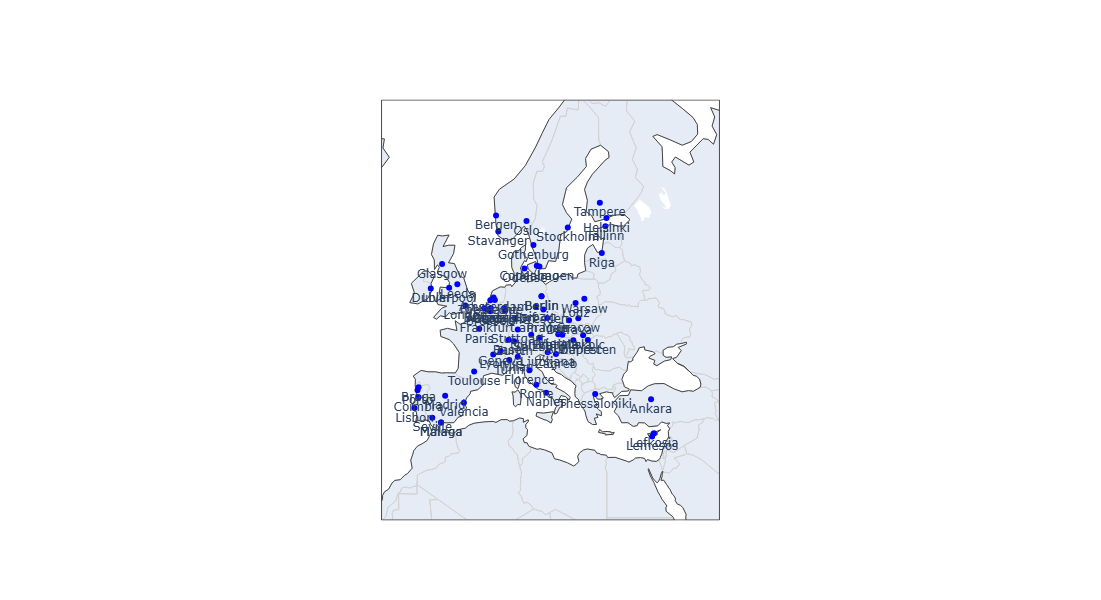

In [714]:
data_copy["Lat_dd"] = data_copy["Lat"].apply(dms_to_dd)
data_copy["Lon_dd"] = data_copy["Lon"].apply(dms_to_dd)

data_copy

fig = go.Figure()

fig.add_trace(go.Scattergeo(
    lon=cities_info["Lon_dd"],
    lat=cities_info["Lat_dd"],
    text=data_copy["City"], 
    mode="markers+text",
    textposition="bottom center",
    marker=dict(size=6, color="blue"),
    customdata = data_copy[["Country", "Population", "Average Monthly Salary", "Average Cost of Living"]].values,
    hovertemplate=(
        "<b>%{text}</b><br>" +
        "Country = %{customdata[0]}<br>" +
        "Population = %{customdata[1]}<br>" +
        "Average Monthly Salary = %{customdata[2]}<br>" +
        "Average Cost of Living = %{customdata[3]}<extra></extra>"
    ),
))


fig.update_layout(
        geo=dict(
        scope="world",
        projection_type="mercator",
        showcountries=True,
        countrycolor="lightgray",
        lataxis_range=[30, 72],
        lonaxis_range=[-15, 45], 
    ),
    height=600
)

fig.show()

In [712]:
data_copy.to_csv("city_data_copy.csv")